# DSCI 100 Project Final Report – Group Component

Created by Chrissy DIng, Kaylee Hogeboom, Rhett Cotton, and Trinity Chan

### 1. Introduction

#### The addressed broad question: "We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts"

#### Specifc Question: Can age and experience predict the total hours played so we can target similar players for large-data recruitment?
Using provided datasets, We'll investigate this question for Frank Wood's CS research group's game, PlaiCraft. The main dataset used will be players.csv.


#### Pre-Inspection Details

 - Collection period: May 1-September 1, 2024
 - Session tracking duration: once game was opened to closed
 - Two NA values (players.csv)
     - I kept them as other variables in those rows may be valuable for visualizations and summaries

<mark>Add more about background info, how data was collected, etc.<mark>

In [78]:
# Now, let's load in some R packages!
library(tidyverse)
library(ggplot2)
library(RColorBrewer)
library(tidymodels)
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




### 2. Methods & Results

#### i) Data Descriptions and Inspecting the Datasets with R Functions and Summaries

In [2]:
#load the dataset we'll be working with
url_players <- "https://raw.githubusercontent.com/tchan0717/dsci-100-2025w1-group-36/refs/heads/main/data/players.csv"
players <- read_csv(url_players)

head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


#### Description of the set (players.csv):

- 196 observations, 7 variables about the players:
1. `experience`: *character* - gaming "level" - order: Beginner, Amateur, Regular, Veteran, Pro (most experienced)
2. `subscribe`: *logical* - PlaiCraft newsletter subscription: TRUE="yes", FALSE="no"
3. `hashedEmail`: *character* - email formatted in numbers and letters
4. `played_hours`: *double* - total hours played
5. `name`: *character* - first name
6. `gender`: *character* - gender
7. `age`: *double* - age (years)

##### Issues: 
- `subscribe` is ambiguous - likely indicates newsletter subscription
- `experience` "level" order is unclear
    - Assumed order stated above, but no metadata to verify
 
Tidy data is one variable per column, one observation per row, and one value per cell. Wrangling isn't needed as dataset follows this.

#### Summary #1 - Experience

In [3]:
experience_count <- players |>
                        group_by(experience) |>
                        summarize(count = n())

experience_summary <- experience_count |>
                        ungroup() |>
                        mutate(percent_of_overall_dataset = count/sum(count) * 100) |> 
                        mutate(percent_of_overall_dataset = round(percent_of_overall_dataset, 2)) #round to 2 decimal places
experience_summary

experience,count,percent_of_overall_dataset
<chr>,<int>,<dbl>
Amateur,63,32.14
Beginner,35,17.86
Pro,14,7.14
Regular,36,18.37
Veteran,48,24.49


#### Summary #2 - Played Hours

In [4]:
played_hours_summary <- players |>
                            summarize(mean = mean(played_hours, na.rm = TRUE),
                                      sum = sum(played_hours, na.rm = TRUE),
                                      most = max(played_hours),
                                      least = min(played_hours)) |>
                            mutate(across(mean:least, ~ round(.x, 2)))    
played_hours_summary       

mean,sum,most,least
<dbl>,<dbl>,<dbl>,<dbl>
5.85,1145.8,223.1,0


#### Summary #3 - Gender

In [5]:
gender_count <- players |>
                    group_by(gender) |>
                    summarize(count = n())

gender_summary <- gender_count |>
                        ungroup() |>
                        mutate(percent_of_overall_dataset = count/sum(count) * 100) |>
                        mutate(percent_of_overall_dataset = round(percent_of_overall_dataset, 2))
gender_summary

gender,count,percent_of_overall_dataset
<chr>,<int>,<dbl>
Agender,2,1.02
Female,37,18.88
Male,124,63.27
Non-binary,15,7.65
Other,1,0.51
Prefer not to say,11,5.61
Two-Spirited,6,3.06


#### Summary #4 - Age (Years)

In [6]:
age_summary <- players |>
                    summarize(mean = mean(Age, na.rm = TRUE),
                              oldest = max(Age, na.rm = TRUE),
                              youngest = min(Age, na.rm = TRUE)) |>
                    mutate(across(mean:youngest, ~ round(.x, 2)))    
age_summary   

mean,oldest,youngest
<dbl>,<dbl>,<dbl>
21.14,58,9


In [7]:
# Now, let's read in sessions.csv!
url_sessions <- "https://raw.githubusercontent.com/tchan0717/dsci-100-2025w1-group-36/refs/heads/main/data/sessions.csv"
sessions <- read_csv(url_sessions)
head(sessions)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


#### Description of the set (sessions.csv):

- 1535 observations, 5 variables:
1. `hashedEmail`: *character* - email formatted in numbers and letters
2. `start_time`: *character* - session start time (DD/MM/YYYY", "time (24-hour-clock)")
4. `end_time`: *character* - session end time ("DD/MM/YYYY", "time (24-hour-clock)")
5. `original_start_time`: *double* - session start time in UNIX (milliseconds)
6. `original_end_time`: *double* - session end time in UNIX (milliseconds)

This dataset isn't the focus, but beneficial for further exploratory visualizations. It's already tidy as well.

#### Summary #5 - Total Sessions

In [8]:
# Because dataset is not the focus, we'll just summarize the variable I will be using in a visualization later.
total_sessions_count <- sessions |>
                                group_by(hashedEmail) |>
                                summarize(count = n())

total_sessions_summary <- total_sessions_count |>
                                summarize(mean = mean(count, na.rm = TRUE),
                                      median = median(count, na.rm = TRUE),
                                      most = max(count),
                                      least = min(count)) |>
                                mutate(across(mean:least, ~ round(.x, 2)))  
total_sessions_summary

mean,median,most,least
<dbl>,<dbl>,<dbl>,<dbl>
12.28,1,310,1


In [9]:
# I will merge the datasets together too to simplify future explorations:
sessions_players_merged <- merge(players, sessions, by = "hashedEmail", all = TRUE)
head(sessions_players_merged)

,hashedEmail,experience,subscribe,played_hours,name,gender,Age,start_time,end_time,original_start_time,original_end_time
,<chr>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,TRUE,1.5,Isaac,Male,20,23/05/2024 00:22,23/05/2024 01:07,1.71642e+12,1.71643e+12
2,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,TRUE,1.5,Isaac,Male,20,22/05/2024 23:12,23/05/2024 00:13,1.71642e+12,1.71642e+12
3,055d1a2002f6308a95b03b8d17af28f43e9f91ca8b1e1fc439bf4d08b22e7c0f,Veteran,TRUE,0.0,Frankie,Male,17,NA,NA,NA,NA
4,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Pro,FALSE,0.4,Lyra,Male,21,28/06/2024 04:28,28/06/2024 04:58,1.71955e+12,1.71955e+12
5,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Beginner,TRUE,0.1,Osiris,Male,17,19/09/2024 21:01,19/09/2024 21:12,1.72678e+12,1.72678e+12
6,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Regular,TRUE,5.6,Winslow,Male,17,30/08/2024 03:40,30/08/2024 04:04,1.72499e+12,1.72499e+12


#### ii) Exploratory Data Analysis and Visualization

Let's create visualizations to seek out relationships and overlooked issues.

#### Visualization #1

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


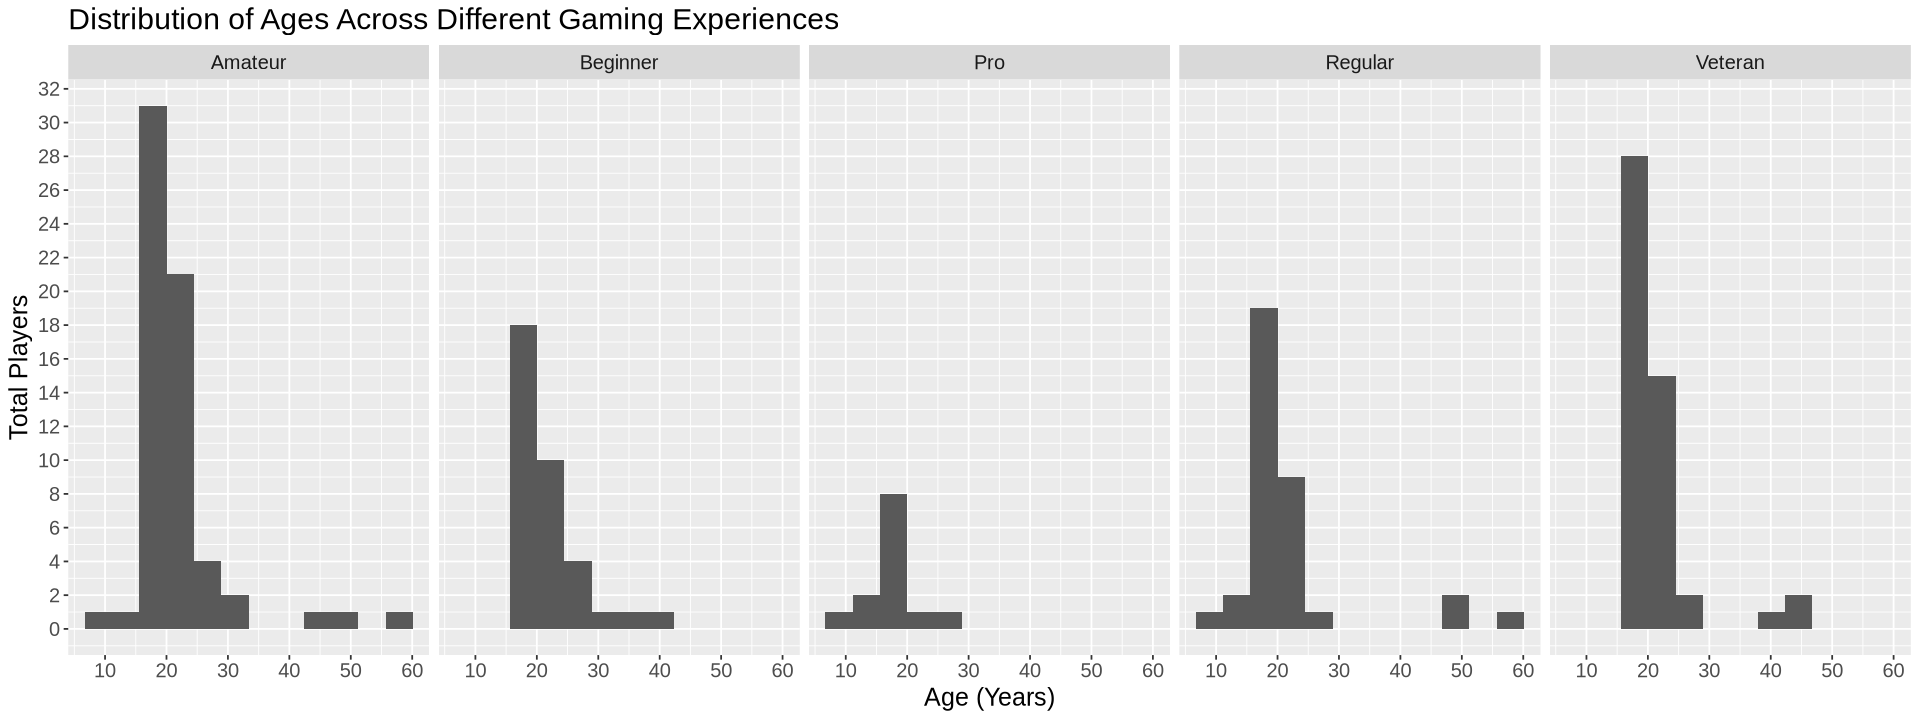

In [10]:
options(repr.plot.width = 16, repr.plot.height = 6)

age_histogram <- ggplot(players, aes(x = Age)) +
                    geom_histogram(bins = 12) +
                    labs(x = "Age (Years)", y = "Total Players") +
                    ggtitle("Distribution of Ages Across Different Gaming Experiences") +
                    scale_y_continuous(breaks = seq(0, 32, by = 2)) +
                    scale_x_continuous(breaks = seq(0, 60, by = 10)) +
                    facet_grid(cols = vars(experience)) +
                    theme(text = element_text(size = 15))
age_histogram

- Majority ~17 years old
- Numerous teenagers and young adults
   - Few young children and adults
- Many Amateurs and Veterans
- Age &ne; to gaming experience

#### Visualization #2

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


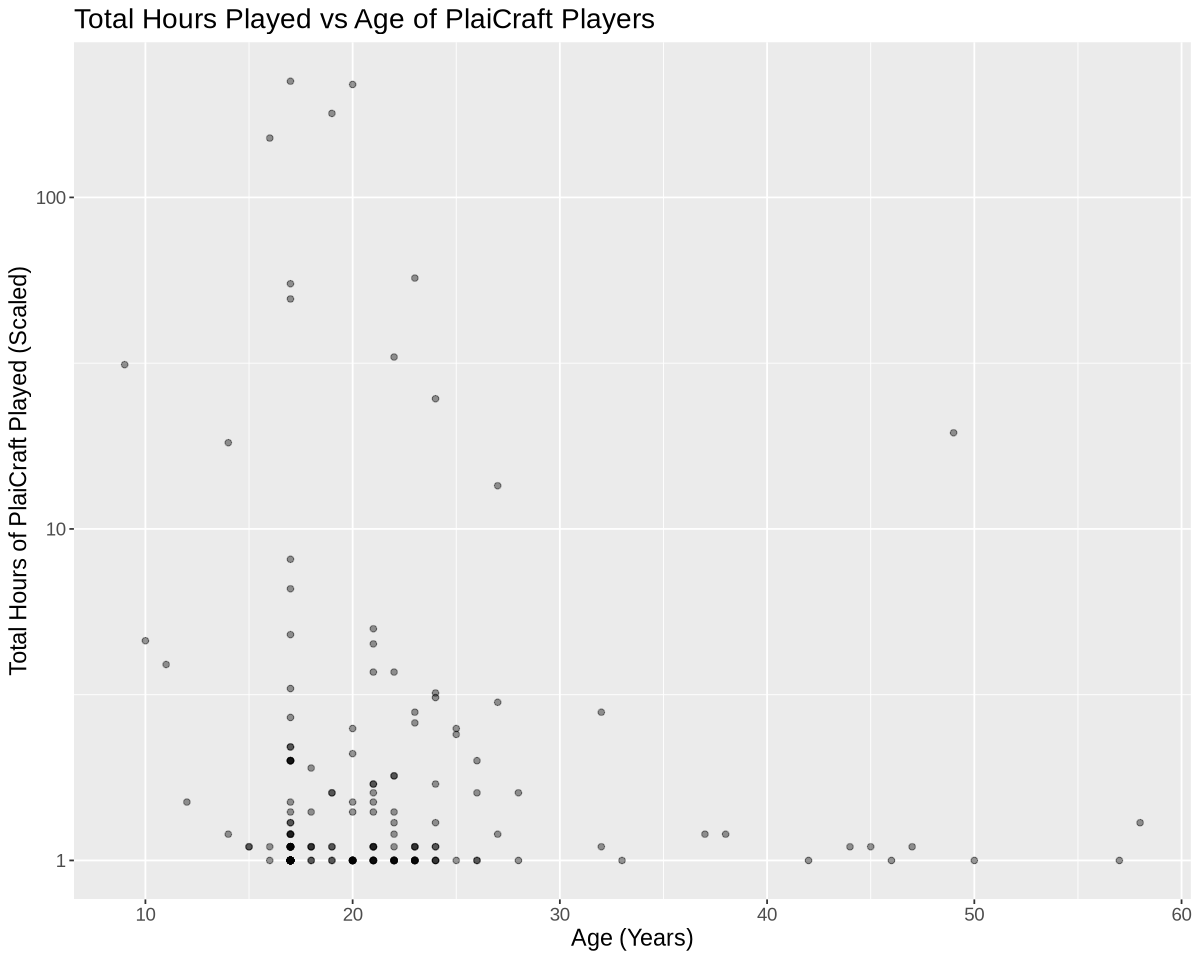

In [11]:
options(repr.plot.width = 10, repr.plot.height = 8)

played_hours_age_plot <- ggplot(players, aes(x = Age, y = played_hours + 1)) + #add +1 so that when we log our y-axis, the 0 values won't be infinity
                            geom_point(alpha = 0.4) +
                            labs(x = "Age (Years)", y = "Total Hours of PlaiCraft Played (Scaled)") +
                            ggtitle("Total Hours Played vs Age of PlaiCraft Players") +
                            scale_y_log10() +
                            theme(text = element_text(size = 14))
played_hours_age_plot

- No relationship nor clear trend
    - Widespread points
- Condensed near bottom of graph
- Insinuates teens and young adults play more
    - Likely player dependent though

#### Visualization #3

`summarise()` has grouped output by 'hashedEmail', 'played_hours'. You can
override using the `.groups` argument.


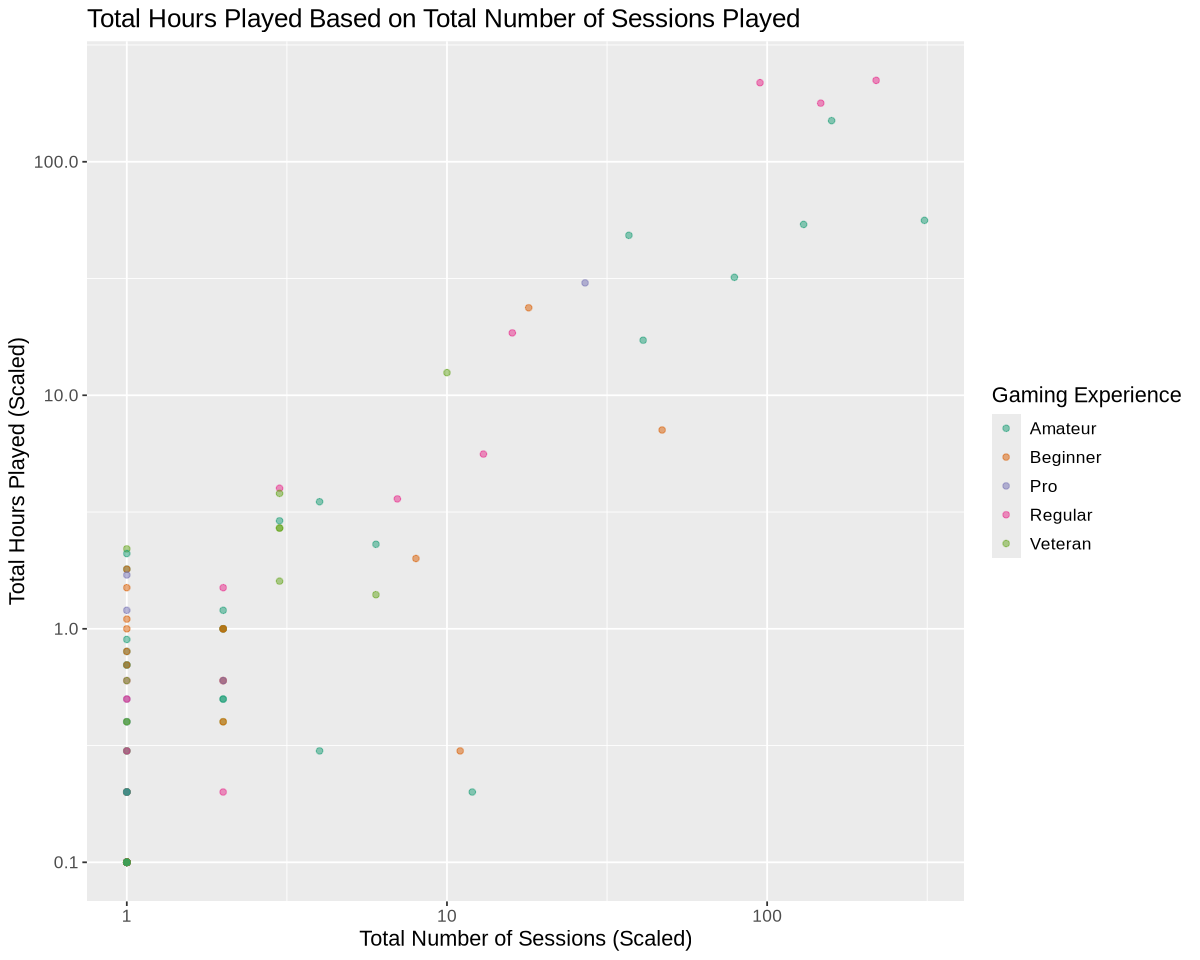

In [12]:
options(repr.plot.width = 10, repr.plot.height = 8)

sessions_hours_total <- sessions_players_merged |>
                        select(hashedEmail, played_hours, experience) |>
                        filter(played_hours != 0) |>
                        group_by(hashedEmail, played_hours, experience) |>
                        summarize(count = n()) #summarizing how many sessions each player played

experience_sessions_plot <- sessions_hours_total |>
                        ggplot(aes(x = count, y = played_hours, color = experience)) +
                            geom_point(alpha = 0.5) +
                            labs(x = "Total Number of Sessions (Scaled)", y = "Total Hours Played (Scaled)", colour = "Gaming Experience") +
                            ggtitle("Total Hours Played Based on Total Number of Sessions Played") +
                            scale_color_brewer(palette = "Dark2") +
                            scale_y_log10() +
                            scale_x_log10() +
                            theme(text = element_text(size = 13))
experience_sessions_plot                        

- Strong, positive relationship
    - Variables increase together
- Identical session counts &ne; identical hours played
- Gaming experience fairly scattered
    - Some Regulars and Amateurs played the most sessions and hours

#### Visualization #4

`summarise()` has grouped output by 'hashedEmail', 'played_hours'. You can
override using the `.groups` argument.


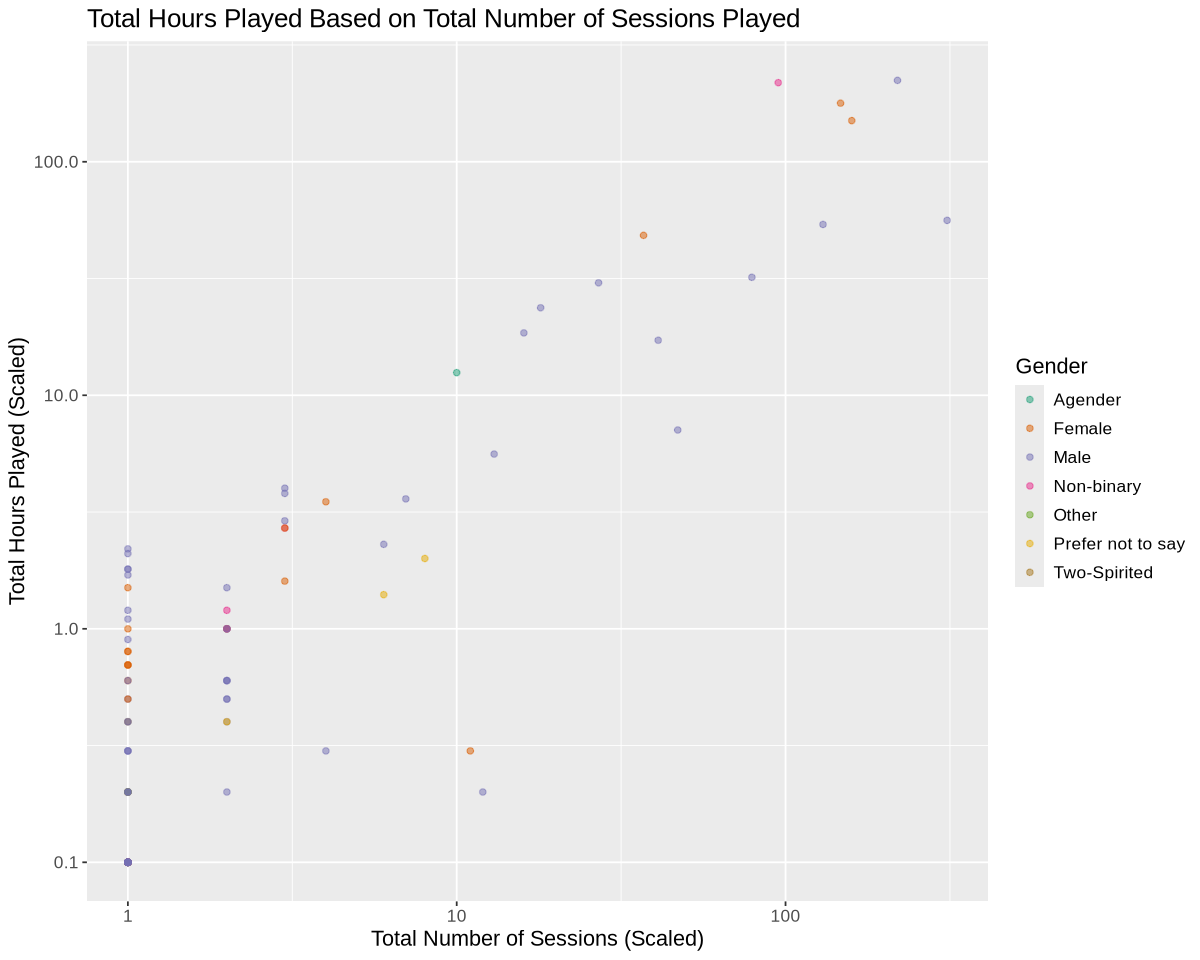

In [13]:
options(repr.plot.width = 10, repr.plot.height = 8)

sessions_hours_total_2 <- sessions_players_merged |>
                        select(hashedEmail, played_hours, gender) |>
                        filter(played_hours != 0) |>
                        group_by(hashedEmail, played_hours, gender) |>
                        summarize(count = n())

gender_sessions_plot <- sessions_hours_total_2 |>
                        ggplot(aes(x = count, y = played_hours, color = gender)) +
                            geom_point(alpha = 0.5) +
                            labs(x = "Total Number of Sessions (Scaled)", y = "Total Hours Played (Scaled)", colour = "Gender") +
                            ggtitle("Total Hours Played Based on Total Number of Sessions Played") +
                            scale_color_brewer(palette = "Dark2") +
                            scale_y_log10() +
                            scale_x_log10() +
                            theme(text = element_text(size = 13))
gender_sessions_plot

Visualization #3 with gender instead:
- Gender is scattered
- Males dominate outer range
   - Play more hours and sessions 

#### iii) KNN Regression Model and Data Analysis

Now, let's make the regression model! The steps we will follow are outlined below:

1. Mutate "experience"
2. Inspect and clean data (eg.handle NA values)
3. Split dataset
      - 75% training, 25% testing
4. Tune training set
      - Scale predictors
5. Cross-validate training set
      - 5 folds
      - Tested neighbors differ by 4; neighbors = 1,5,...196
6. Find optimal *k*, refit model, assess on testing data for RMSPE

In [14]:
#Step 1 and 2
players_tidy <- players |>
                    mutate(experience = factor(experience,
                           levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"),
                           ordered = TRUE),
                           experience_num = as.numeric(experience)) |>
                           select(played_hours, experience_num, Age) |>
                           na.omit(played_hours)
head(players_tidy)

played_hours,experience_num,Age
<dbl>,<dbl>,<dbl>
30.3,5,9
3.8,4,17
0.0,4,17
0.7,2,21
0.1,3,21
0.0,2,17


In [15]:
#Step 3 and 4
set.seed(1234)
players_split <- initial_split(players_tidy, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode("regression")

players_recipe <- recipe(played_hours ~., data = players_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

players_workflow <- workflow() |>
                        add_recipe(players_recipe) |>
                        add_model(players_spec)
players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [68]:
# Step 5
set.seed(1234)
gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 3))

players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_results <- players_workflow |>
                        tune_grid(resamples = players_vfold, grid = gridvals) |>
                        collect_metrics() |>
                        filter(.metric == "rmse")
head(players_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,40.91332,5,8.063748,Preprocessor1_Model01
4,rmse,standard,34.94656,5,5.528236,Preprocessor1_Model02
7,rmse,standard,29.47816,5,5.794990,Preprocessor1_Model03
10,rmse,standard,30.33832,5,5.574974,Preprocessor1_Model04
13,rmse,standard,29.71904,5,6.230914,Preprocessor1_Model05
16,rmse,standard,29.89624,5,5.985292,Preprocessor1_Model06


In [69]:
set.seed(1234)
players_min <- players_results |>
                    slice_min(mean, n = 1) #this shows the best "k" to use
players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
100,rmse,standard,28.61884,5,7.86778,Preprocessor1_Model34


In [70]:
# Step 6
set.seed(1234)
k_min <- players_min |>
          pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
          set_engine("kknn") |>
          set_mode("regression")

players_best_fit <- workflow() |>
          add_recipe(players_recipe) |>
          add_model(players_best_spec) |>
          fit(data = players_training)

players_summary <- players_best_fit |>
           predict(players_testing) |>
           bind_cols(players_testing) |>
           metrics(truth = played_hours, estimate = .pred)
players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,11.301323152
rsq,standard,0.004898366
mae,standard,9.753510204


In [34]:
# Final model
players_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 100) |>
                        set_engine("kknn") |>
                        set_mode("regression")

players_recipe_final <- recipe(played_hours ~., data = players_tidy) |>
                            step_center(all_predictors()) |>
                            step_scale(all_predictors())

players_fit_final <- workflow() |>
                        add_recipe(players_recipe_final) |>
                        add_model(players_spec_final) |>
                        fit(players_tidy)

#### Trying the Model

In [95]:
set.seed(1234)
new_obs <- tibble(Age = sample(1:58, size = 196, replace = TRUE),
                  experience_num = sample(1:5, size = 196, replace = TRUE))

predict_new_obs <- players_fit_final |>
                    predict(new_obs) |>
                    bind_cols(new_obs)

head(predict_new_obs)

.pred,Age,experience_num
<dbl>,<int>,<int>
7.298,28,5
10.262,16,2
5.874,58,1
4.237,22,1
5.799,37,3
5.079,44,1


#### iv) Visualizations of Analysis

#### Visualization #5

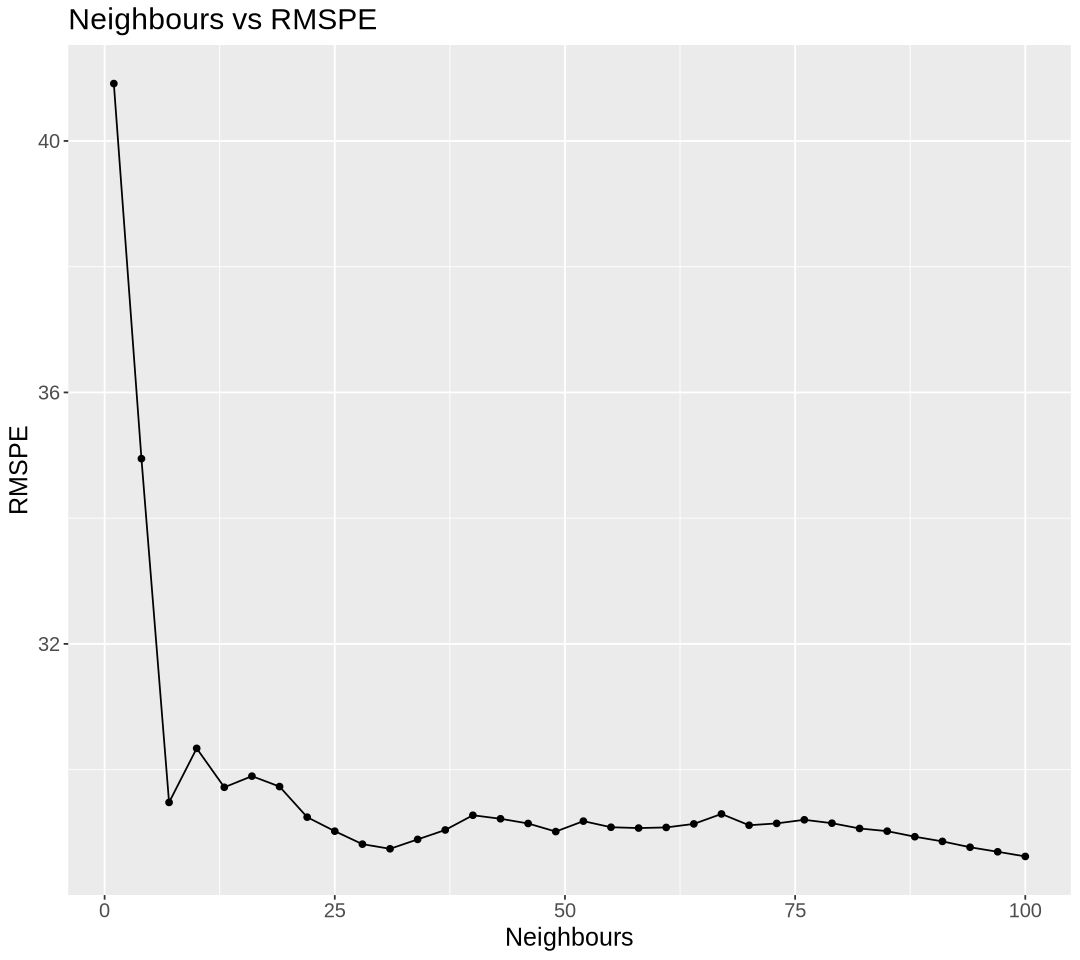

In [35]:
options(repr.plot.width = 9, repr.plot.height = 8)
k_rmspe_plot <- players_results |>
                    ggplot(aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbours", y = "RMSPE") +
                    ggtitle("Neighbours vs RMSPE") +
                    theme(text = element_text(size = 15))
k_rmspe_plot

#### Visualization #6

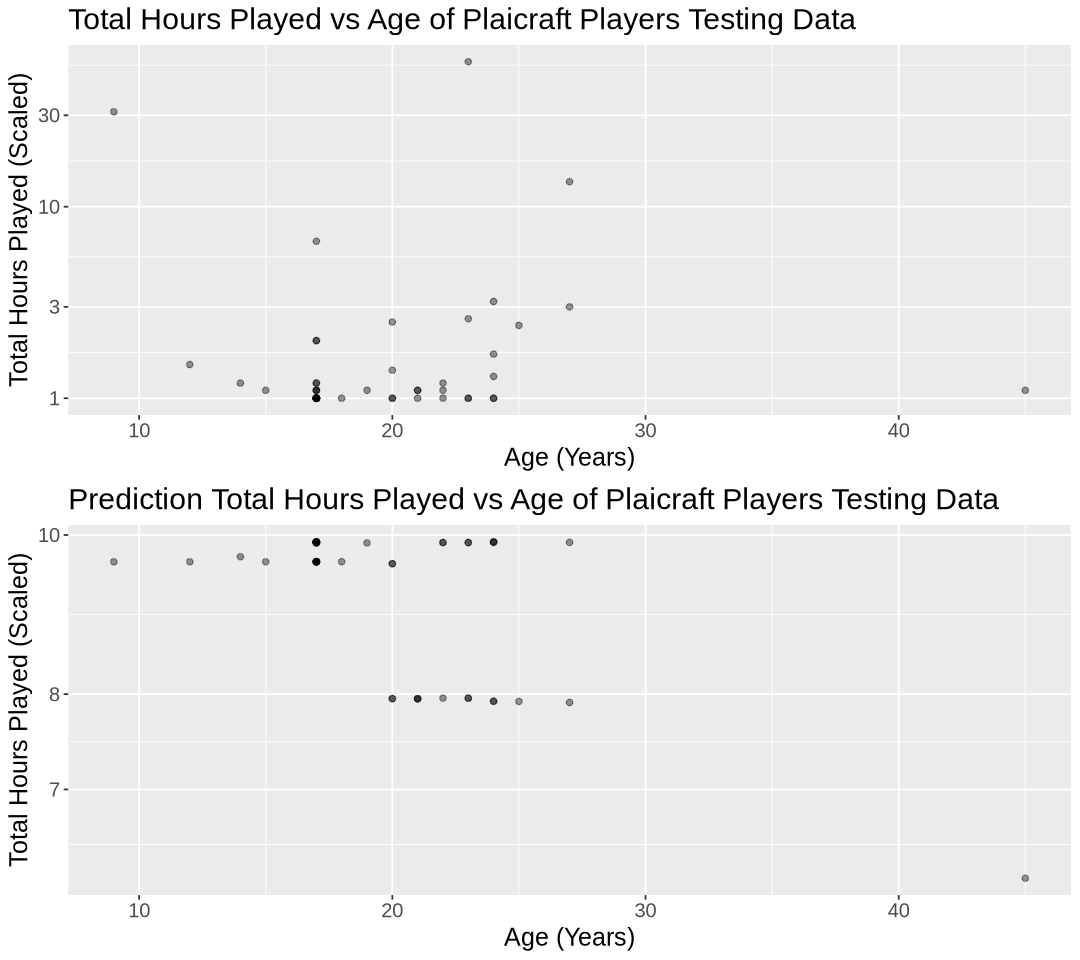

In [82]:
options(repr.plot.width = 9, repr.plot.height = 8)
testing_data_plot <- players_testing |>
                            ggplot(aes(x = Age, y = played_hours + 1)) +
                            geom_point(alpha = 0.4) + 
                            labs(x = "Age (Years)", y = "Total Hours Played (Scaled)") +
                            ggtitle("Total Hours Played vs Age of Plaicraft Players Testing Data") +
                            scale_y_log10() +
                            theme(text = element_text(size = 15))

testing_preds <- players_best_fit |>
  predict(players_testing) |>
  bind_cols(players_testing)

predicted_testing_plot <- ggplot(testing_preds, aes(x = Age, y = .pred)) +
                              geom_point(alpha = 0.4) +
                              labs(x = "Age (Years)", y = "Total Hours Played (Scaled)") +
                              ggtitle("Prediction Total Hours Played vs Age of Plaicraft Players Testing Data") +
                              scale_y_log10() +
                              theme(text = element_text(size = 15))

grid.arrange(testing_data_plot, predicted_testing_plot)

#### Visualization #7

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


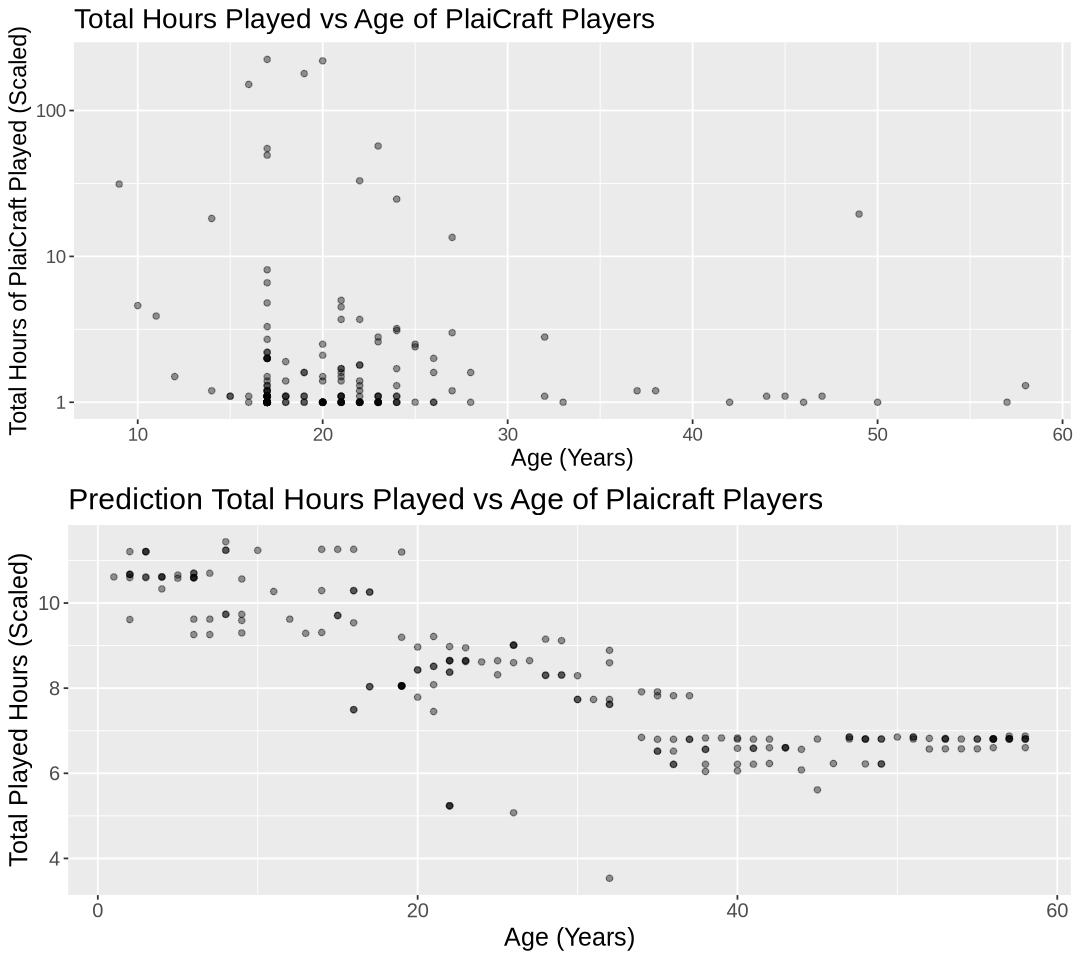

In [100]:
options(repr.plot.width = 9, repr.plot.height = 8)
new_obs_plot <- predict_new_obs_tidy |>
                    ggplot(aes(x = Age, y = .pred + 1)) +
                    geom_point(alpha = 0.4) +
                    labs(x = "Age (Years)", y = "Total Played Hours (Scaled)") +
                    ggtitle("Prediction Total Hours Played vs Age of Plaicraft Players") +
                    theme(text = element_text(size = 15))

grid.arrange(played_hours_age_plot, new_obs_plot)

In [12]:
#Make viualizations based on performed regression

### 3. Discussion

- <mark>Summarize findings
- <mark>Discuss if this what is what was expected
- <mark>What impact do the findings have
- <mark>Are there any future questions of interest

### GitHub Repository

https://github.com/tchan0717/dsci-100-2025w1-group-36.git

### References

Wickham, Hadley, and Garrett Grolemund. 2016. R for Data Science: Import, Tidy, Transform, Visualize, and Model Data. O’Reilly. https://r4ds.had.co.nz/.
\
\
The Pacific Laboratory of Artificial Intelligence. FAQ. Plaicraft. https://plaicraft.ai/faq. 